<a href="https://colab.research.google.com/github/MauricioUhlig/trabalhos_redes_neurais/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Base de dados
[Daily Climate time series data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data)

Conjunto de dados para desenvolvedores interessados em treinamento de modelos de previsão do tempo para o clima indiano. Contém dados de Delhi, Índia, de **1º de janeiro de 2013 a 24 de abril de 2017**  . Os 4 parâmetros são:
temperatura média, umidade, velocidade do vento, pressão média.


Path to dataset files: /kaggle/input/daily-climate-time-series-data
          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


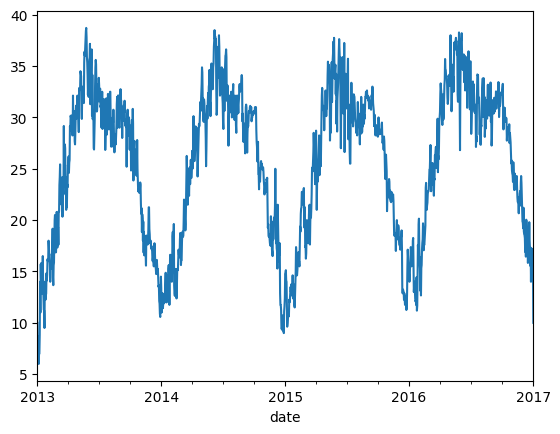

In [49]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

print("Path to dataset files:", path)

# Carregar os dados
df_train = pd.read_csv(path+'/DailyDelhiClimateTrain.csv', parse_dates = ['date'], index_col = ['date'])
df_test = pd.read_csv(path+'/DailyDelhiClimateTest.csv', parse_dates = ['date'], index_col = ['date'])

df_train['meantemp'].plot()
print(df_train.describe())

## Separação treinamento, validação e testes

In [50]:
num_train_samples = int(0.75 * len(df_train))
num_val_samples = int(0.25 * len(df_train))
num_test_samples = len(df_test)
print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

print(len(df_train))

num_train_samples: 1096
num_val_samples: 365
num_test_samples: 114
1462


In [51]:
mean = df_train[:num_train_samples].mean(axis=0)
df_train -= mean
print('mean',mean)
std = df_train[:num_train_samples].std(axis=0)
df_train /= std
print('std',std)

mean meantemp          24.962893
humidity          61.424826
wind_speed         6.682864
meanpressure    1008.286461
dtype: float64
std meantemp         7.413768
humidity        16.770290
wind_speed       4.730118
meanpressure     7.624968
dtype: float64


## Escolhas dos parametros e criação dos datasets
- `sampling_rate = 1`: Como a granulometria já está em um registro por dia, já está com resolução boa e não tem necessidade de 'pular' valores um realização de amostragens por este motivo, o sampling_rate será 1, onde todos os registros serão considerados

- `sequence_length = 30`: A sequencia será de 30 dias, fechando então em previsões mensais

- `delay = 7`: 7 dias de delay prevê a média semanal, suavizando variações aleatórias

In [52]:
import numpy as np
from tensorflow import keras

sampling_rate = 1
sequence_length = 30
delay = 7

batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    df_train[:-delay],
    targets=df_train['meantemp'][delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    end_index=num_train_samples
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    df_train[:-delay],
    targets=df_train['meantemp'][delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    df_test[:-delay],
    targets=df_test['meantemp'][delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
)

In [53]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

for samples, targets in test_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 30, 4)
targets shape: (256,)
samples shape: (78, 30, 4)
targets shape: (78,)


## Baseline

In [54]:
def evaluate_naive_method(dataset):
  total_abs_err = 0
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 0] * std[0] + mean[0]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print("Validation MAE (naive method):", evaluate_naive_method(val_dataset))
print("Test MAE (naive method):", evaluate_naive_method(test_dataset))

Validation MAE (naive method): 27.963649066588804
Test MAE (naive method): 176.02244380510496


## Modelos em Keras

In [60]:
from tensorflow import keras
from tensorflow.keras import layers

def compile_and_fit(intermediate_layers, model_save_name):
  inputs = keras.Input(shape=(sequence_length, df_train.shape[-1]))
  x = intermediate_layers(inputs)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  callbacks = [keras.callbacks.ModelCheckpoint(model_save_name, save_best_only=True)]

  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
  return keras.models.load_model(model_save_name)

### LSTM

In [61]:
lstm = lambda inputs : layers.LSTM(16)(inputs)

model_lstm = compile_and_fit(lstm, "lstm.keras")
print(f"Test MAE: {model_lstm.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.5139 - mae: 0.6144 - val_loss: 0.4041 - val_mae: 0.5492
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3841 - mae: 0.5252 - val_loss: 0.3362 - val_mae: 0.4966
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3148 - mae: 0.4680 - val_loss: 0.2917 - val_mae: 0.4586
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2678 - mae: 0.4271 - val_loss: 0.2640 - val_mae: 0.4331
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2370 - mae: 0.4004 - val_loss: 0.2451 - val_mae: 0.4152
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2176 - mae: 0.3850 - val_loss: 0.2361 - val_mae: 0.4073
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1929 - mae: 0.3614 - val_loss: 0.2260 - val_mae: 0.3973
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1714 - mae: 0.3399 - val_loss: 0.2149 - val_mae: 0.3865
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1631 - mae: 0.3303 - 

### LSTM com Dropout

In [62]:
def lstm_dropout(inputs):
  x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
  x = layers.Dropout(0.5)(x)
  return x

model_lstm_dropout = compile_and_fit(lstm_dropout, "lstm_dropout.keras")
print(f"Test MAE: {model_lstm_dropout.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - loss: 1.1877 - mae: 0.9365 - val_loss: 0.7162 - val_mae: 0.7319
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.7132 - mae: 0.7157 - val_loss: 0.5071 - val_mae: 0.6080
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.5805 - mae: 0.6380 - val_loss: 0.3748 - val_mae: 0.5197
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.4457 - mae: 0.5503 - val_loss: 0.3008 - val_mae: 0.4641
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.3689 - mae: 0.4958 - val_loss: 0.2565 - val_mae: 0.4279
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.3107 - mae: 0.4568 - val_loss: 0.2278 - val_mae: 0.4043
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.3089 - mae: 0.4463 - val_loss: 0.2234 - val_mae: 0.4004
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.2550 - mae: 0.4101 - val_loss: 0.2107 - val_mae: 0.3883
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.2603 - mae: 0

### LSTM Bidirecional

In [63]:
lstm_bidirecional = lambda inputs: layers.Bidirectional(layers.LSTM(16))(inputs)

model_lstm_bidirecional = compile_and_fit(lstm_bidirecional,"lstm_bidirecional.keras")
print(f"Test MAE: {model_lstm_bidirecional.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.5083 - mae: 0.5982 - val_loss: 0.2827 - val_mae: 0.4445
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2725 - mae: 0.4328 - val_loss: 0.2033 - val_mae: 0.3775
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1954 - mae: 0.3651 - val_loss: 0.1603 - val_mae: 0.3371
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1584 - mae: 0.3295 - val_loss: 0.1411 - val_mae: 0.3168
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1406 - mae: 0.3097 - val_loss: 0.1284 - val_mae: 0.3013
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1187 - mae: 0.2837 - val_loss: 0.1154 - val_mae: 0.2850
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1022 - mae: 0.2599 - val_loss: 0.1051 - val_mae: 0.2697
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0910 - mae: 0.2443 - val_loss: 0.1156 - val_mae: 0.2810
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0823 - mae: 0.2287 -